In [ ]:
import logging
import os
import s3fs
import trino.dbapi
import pandas as pd
import numpy as np

## Variables

In [2]:
# Trino
TRINO_TABLE_NAME_PREFIX = "rep"
TRINO_HOST_URL = "192.168.1.4"
TRINO_HOST_PORT = 8080
TRINO_USER = "root"
TRINO_CATALOG = "datalake"
TRINO_SCHEMA = "staging"

## Funciones

In [3]:
def create_trino_connection():
    conn = trino.dbapi.connect(
        host=TRINO_HOST_URL,
        port=TRINO_HOST_PORT,
        user=TRINO_USER,
        catalog=TRINO_CATALOG,
        schema=TRINO_SCHEMA
    )
    return conn

## Crear conexión

In [4]:
cur_trino = create_trino_connection().cursor()

## Hacer query

In [5]:
query = """
SELECT edad_agrupada, sexo_num, COUNT(*) AS frecuencia
FROM (
    SELECT *,
        CASE
            WHEN edad_final BETWEEN 0 AND 9 THEN '0 a 9'
            WHEN edad_final BETWEEN 10 AND 19 THEN '10 a 19'
            WHEN edad_final BETWEEN 20 AND 29 THEN '20 a 29'
            WHEN edad_final BETWEEN 30 AND 39 THEN '30 a 39'
            WHEN edad_final BETWEEN 40 AND 49 THEN '40 a 49'
            WHEN edad_final BETWEEN 50 AND 59 THEN '50 a 59'
            WHEN edad_final BETWEEN 60 AND 69 THEN '60 a 69'
            WHEN edad_final BETWEEN 70 AND 79 THEN '70 a 79'
            WHEN edad_final BETWEEN 80 AND 89 THEN '80 a 89'
            WHEN edad_final BETWEEN 90 AND 99 THEN '90 a 99'
            WHEN edad_final BETWEEN 100 AND 110 THEN '100 a 110'
            ELSE NULL
        END AS edad_agrupada
    FROM datalake.staging.rep
    WHERE edad_final != 99999 AND sexo_num BETWEEN 1 AND 2
) AS subquery
GROUP BY edad_agrupada, sexo_num
"""

cur_trino.execute(query)

## Traer dataframe

In [6]:
df = pd.DataFrame(cur_trino.fetchall(), columns=[i[0] for i in cur_trino.description])
print(df)

   edad_agrupada  sexo_num  frecuencia
0        20 a 29       1.0     1478147
1        70 a 79       2.0      690157
2        20 a 29       2.0     1420605
3        60 a 69       2.0     1135893
4        40 a 49       2.0     1421299
5        50 a 59       1.0     1348244
6        90 a 99       1.0      125976
7        90 a 99       2.0      132485
8        70 a 79       1.0      587060
9          0 a 9       2.0     1070634
10       50 a 59       2.0     1391305
11     100 a 110       2.0       83454
12       80 a 89       1.0      262983
13       10 a 19       1.0     1278661
14       60 a 69       1.0     1043207
15       80 a 89       2.0      348010
16       10 a 19       2.0     1227185
17     100 a 110       1.0      105826
18       40 a 49       1.0     1446997
19       30 a 39       1.0     1748153
20       30 a 39       2.0     1667181
21         0 a 9       1.0     1112427


## Generar gráfico pirámide demográfica

In [7]:
# Utilizar pivot_table para convertir el formato de la tabla
tabla_pivot = df.pivot_table(index='edad_agrupada', columns='sexo_num', values='frecuencia', aggfunc='sum')

# Ordenar tabla_pivot por 'edad_num' en orden ascendente
tabla_pivot.index = pd.Categorical(tabla_pivot.index,
                          categories=["0 a 9", "10 a 19", "20 a 29", "30 a 39", "40 a 49", "50 a 59", "60 a 69", "70 a 79", "80 a 89", "90 a 99", "100 a 110"],
                          ordered=True)
tabla_pivot = tabla_pivot.sort_index()

# Generar columna que sea el index de tabla_pivot
tabla_pivot["edad_agrupada"] = tabla_pivot.index

# Calcular la suma total de frecuencias para hombres y mujeres
total_hombres = tabla_pivot[1].sum()
total_mujeres = tabla_pivot[2].sum()

# Convertir las frecuencias en porcentaje
tabla_pivot[1] = (tabla_pivot[1] / total_hombres) * 100
tabla_pivot[2] = (tabla_pivot[2] / total_mujeres) * 100

# Redondear los porcentajes a un dígito después del punto decimal
tabla_pivot[1] = tabla_pivot[1].round(1)
tabla_pivot[2] = tabla_pivot[2].round(1)

# Crear un nuevo DataFrame con los porcentajes
df_porcentaje = pd.DataFrame({"Edad": tabla_pivot["edad_agrupada"], "Male": tabla_pivot[1], "Female": tabla_pivot[2]})


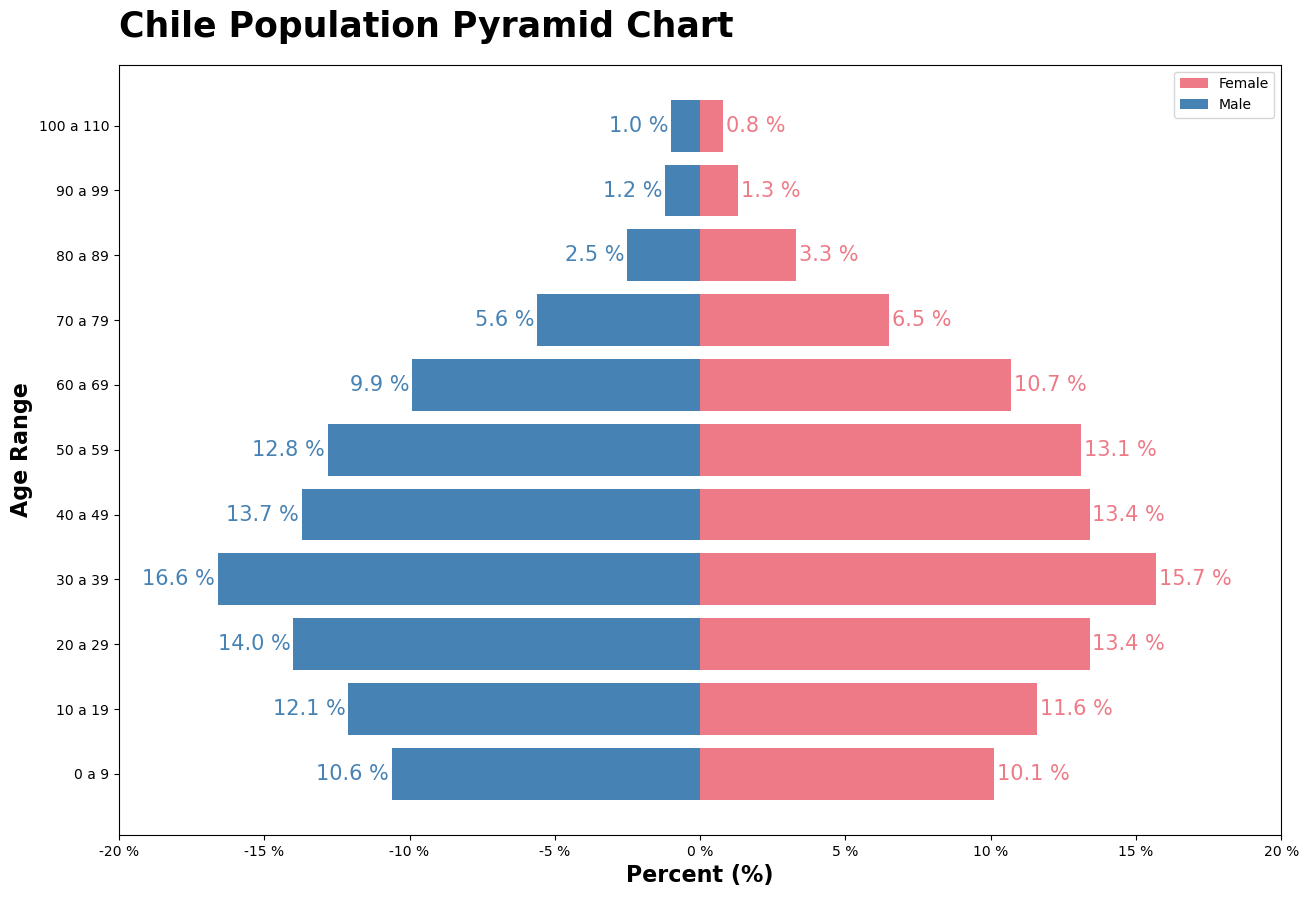

In [8]:
df_porcentaje["Mujeres_Left"] = 0
df_porcentaje["Mujeres_Width"] = df_porcentaje["Female"]

df_porcentaje["Hombres_Left"] = -df_porcentaje["Male"]
df_porcentaje["Hombres_Width"] = df_porcentaje["Male"]

df_porcentaje

female_color = "#ee7a87"
male_color = "#4682b4"

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))

plt.barh(y=df_porcentaje["Edad"], width=df_porcentaje["Mujeres_Width"], color="#ee7a87", label="Female");
plt.barh(y=df_porcentaje["Edad"], width=df_porcentaje["Hombres_Width"], left=df_porcentaje["Hombres_Left"],
         color="#4682b4", label="Male");

for idx in range(len(df_porcentaje)):
    plt.text(x=df_porcentaje["Hombres_Left"][idx]-0.1, y=idx, s="{} %".format(df_porcentaje["Male"][idx]),
             ha="right", va="center",
             fontsize=15, color="#4682b4");
    plt.text(x=df_porcentaje["Mujeres_Width"][idx]+0.1, y=idx, s="{} %".format(df_porcentaje["Female"][idx]),
             ha="left", va="center",
             fontsize=15, color="#ee7a87");

plt.xlim(-20,20);
plt.xticks(range(-20,21,5), ["{} %".format(i) for i in range(-20,21,5)]);

plt.legend(loc="best");

plt.xlabel("Percent (%)", fontsize=16, fontweight="bold")
plt.ylabel("Age Range", fontsize=16, fontweight="bold")
plt.title("Chile Population Pyramid Chart", loc="left", pad=20, fontsize=25, fontweight="bold");

plt.show()